In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
df = pd.read_csv("Dataset_spine.csv")
df.head()

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12,Class_att,Unnamed: 13
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.254400,0.744503,12.5661,14.5386,15.30468,-28.658501,43.5123,Abnormal,NaN
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,0.415186,12.8874,17.5323,16.78486,-25.530607,16.1102,Abnormal,NaN
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,0.474889,26.8343,17.4861,16.65897,-29.031888,19.2221,Abnormal,Prediction is done by using binary classificat...
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,0.369345,23.5603,12.7074,11.42447,-30.470246,18.8329,Abnormal,NaN
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,0.543360,35.4940,15.9546,8.87237,-16.378376,24.9171,Abnormal,NaN


In [5]:
df.columns

Index(['Col1', 'Col2', 'Col3', 'Col4', 'Col5', 'Col6', 'Col7', 'Col8', 'Col9',
       'Col10', 'Col11', 'Col12', 'Class_att', 'Unnamed: 13'],
      dtype='object')

In [8]:
df.drop('Unnamed: 13', inplace=True, axis=1)

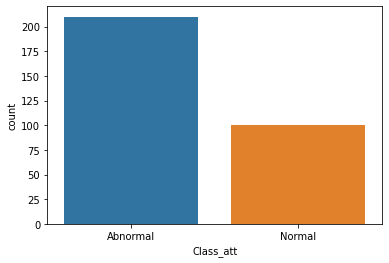

In [9]:
sns.countplot(x = 'Class_att', data=df)

In [10]:
df['Class_att'] = df['Class_att'].astype('category')
encode_map = {
    'Abnormal': 1,
    'Normal': 0
}

df['Class_att'].replace(encode_map, inplace=True)

In [11]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=69)

In [13]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [14]:
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [15]:
## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = trainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train))
## test data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = testData(torch.FloatTensor(X_test))

In [16]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [17]:
#Note that we did not use the Sigmoid activation in our final layer during training. That’s because, we use the 
#nn.BCEWithLogitsLoss() loss function which automatically applies the the Sigmoid activation.

class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(12, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
###################### OUTPUT ######################
cuda:0

cpu


In [19]:
model = binaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=12, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [20]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [21]:
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.69858 | Acc: 54.750
Epoch 002: | Loss: 0.56625 | Acc: 73.000
Epoch 003: | Loss: 0.51259 | Acc: 78.000
Epoch 004: | Loss: 0.46322 | Acc: 82.500
Epoch 005: | Loss: 0.42655 | Acc: 85.000
Epoch 006: | Loss: 0.44889 | Acc: 81.250
Epoch 007: | Loss: 0.41835 | Acc: 82.000
Epoch 008: | Loss: 0.44717 | Acc: 81.000
Epoch 009: | Loss: 0.41636 | Acc: 81.000
Epoch 010: | Loss: 0.41555 | Acc: 83.500
Epoch 011: | Loss: 0.42582 | Acc: 84.000
Epoch 012: | Loss: 0.35678 | Acc: 85.250
Epoch 013: | Loss: 0.33267 | Acc: 87.250
Epoch 014: | Loss: 0.31181 | Acc: 92.250
Epoch 015: | Loss: 0.31352 | Acc: 85.750
Epoch 016: | Loss: 0.28865 | Acc: 92.250
Epoch 017: | Loss: 0.28409 | Acc: 91.500
Epoch 018: | Loss: 0.26664 | Acc: 93.750
Epoch 019: | Loss: 0.28886 | Acc: 87.500
Epoch 020: | Loss: 0.28618 | Acc: 88.000
Epoch 021: | Loss: 0.21802 | Acc: 93.250
Epoch 022: | Loss: 0.21884 | Acc: 93.500
Epoch 023: | Loss: 0.22373 | Acc: 92.750
Epoch 024: | Loss: 0.27108 | Acc: 90.750
Epoch 025: | Los

In [22]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [23]:
confusion_matrix(y_test, y_pred_list)

array([[26,  5],
       [14, 58]], dtype=int64)

In [24]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.65      0.84      0.73        31
           1       0.92      0.81      0.86        72

    accuracy                           0.82       103
   macro avg       0.79      0.82      0.80       103
weighted avg       0.84      0.82      0.82       103

